## Speech recognition

__You should be able to do this exercise after Lecture 9.__

In this exercise, we will work with the <a href="https://arxiv.org/pdf/1804.03209.pdf">Google Speech Command Dataset</a>, which can be downloaded from <a href="http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz">here</a> (note: you do not need to download the full dataset, but it will allow you to play around with the raw audiofiles). This dataset contains 105,829 one-second long audio files with utterances of 35 common words.

We will use a subset of this dataset as indicated in the table below.

| Word | How many? | Class # |
| :-: | :-: | :-: |
| Yes | 4,044 | 3 |
| No | 3,941 | 1 |
| Stop | 3,872 | 2 |
| Go | 3,880 | 0 |

The data is given in the files `XSound.npy` and `YSound.npy`, both of which can be imported using `numpy.load`. `XSound.npy` contains spectrograms (_e.g._, matrices with a time-axis and a frequency-axis of size 62 (time) x 65 (frequency)). `YSound.npy` contains the class number, as indicated in the table above.

__(a)__ Train a convolutional neural network on the data. Find a good set of hyperparameters for the model. Do you think a convolutional neural network is suitable for this kind of problem? Why/why not?

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
tf.random.set_seed(420)
# tf.config.run_functions_eagerly(True)
tf.config.set_visible_devices([], 'GPU')
# device = tf.config.list_physical_devices('GPU')[0]
# tf.config.experimental.set_memory_growth(device, True)


### Loading data

In [3]:
X = np.load('XSound.npy')
y = np.load('YSound.npy')

In [4]:
# 15737 spectograms. Each spectogram is 62 (time) x 65 (frequency) 
X.shape

(15737, 62, 65, 1)

In [5]:
y.shape

(15737,)

In [6]:
def plot_history(history):
    plt.figure()
    plt.title("Learning curves")
    plt.xlabel("Epoch")
    plt.ylabel("Cross entropy loss")
    plt.plot(history.history['loss'], label = 'train')
    plt.plot(history.history['val_loss'], label = 'valid')
    plt.legend()
    plt.show()

    plt.figure()
    plt.title("Learning curves")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.plot(history.history['accuracy'], label = 'train')
    plt.plot(history.history['val_accuracy'], label = 'valid')
    plt.legend()
    plt.show()

### Baseline accuracy
Baseline accuracy is ~25%

In [7]:
pd.Series(y).value_counts()

3    4044
1    3941
0    3880
2    3872
Name: count, dtype: int64

### Preprocessing

We want the target/labels to not be a single value, but a vector that contains the probabilities of the input being a word, i.e. [n, n, n, n] instead of [n] where e.g. [0.7, 0.3, 0.2, 0.2] would mean 70% that the word is yes.



In [8]:
y

array([0, 1, 3, ..., 3, 3, 1], dtype=int32)

In [9]:
def transform_y_to_multiclass_vector_probabilities(y: np.array) -> np.ndarray:
    res = []
    for _class in y:
        transformed = [0, 0, 0 ,0]
        transformed[_class] = 1
        res.append(np.array(transformed))
    return np.array(res)

In [10]:
y = transform_y_to_multiclass_vector_probabilities(y)
y

array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       ...,
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 1, 0, 0]])

### Splitting data into train, validation and test 
60-20-20 split

In [11]:
from sklearn.model_selection import train_test_split

X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=42)
X_train, X_validation, y_train, y_validation= train_test_split(X_, y_, test_size=.25, random_state=42)

### Model development

First we try with a simple CNN with input layer, one convolutional layer, one pooling layer, a dense layer and an output layer.  

In [12]:
from tensorflow.keras import layers

es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights=True)

cnn = tf.keras.models.Sequential([
    layers.Conv2D(16, 3, activation='relu', padding='same', input_shape=X_train[0].shape),
    layers.AveragePooling2D(),
    layers.Flatten(),
    layers.Dense(units=84, activation='relu'),
    layers.Dense(units=4, activation='softmax')
])

cnn.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), metrics = ['accuracy'])
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 65, 16)        160       
                                                                 
 average_pooling2d (AverageP  (None, 31, 32, 16)       0         
 ooling2D)                                                       
                                                                 
 flatten (Flatten)           (None, 15872)             0         
                                                                 
 dense (Dense)               (None, 84)                1333332   
                                                                 
 dense_1 (Dense)             (None, 4)                 340       
                                                                 
Total params: 1,333,832
Trainable params: 1,333,832
Non-trainable params: 0
______________________________________________

In [13]:
history = cnn.fit(X_train, y_train, 
                    epochs = 100, 
                    validation_data=(X_validation, y_validation),
                    callbacks=[es])

Epoch 1/100


2023-11-13 13:56:04.251673: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


296/296 [==============================] - 7s 21ms/step - loss: 0.8176 - accuracy: 0.7161 - val_loss: 0.6496 - val_accuracy: 0.7805
Epoch 2/100
296/296 [==============================] - 9s 29ms/step - loss: 0.5664 - accuracy: 0.8081 - val_loss: 0.5436 - val_accuracy: 0.8173
Epoch 3/100
296/296 [==============================] - 11s 37ms/step - loss: 0.4755 - accuracy: 0.8346 - val_loss: 0.5143 - val_accuracy: 0.8196
Epoch 4/100
296/296 [==============================] - 13s 45ms/step - loss: 0.4129 - accuracy: 0.8574 - val_loss: 0.4563 - val_accuracy: 0.8469
Epoch 5/100
296/296 [==============================] - 11s 36ms/step - loss: 0.3667 - accuracy: 0.8696 - val_loss: 0.4371 - val_accuracy: 0.8501
Epoch 6/100
296/296 [==============================] - 10s 32ms/step - loss: 0.3419 - accuracy: 0.8774 - val_loss: 0.4218 - val_accuracy: 0.8571
Epoch 7/100
296/296 [==============================] - 12s 42ms/step - loss: 0.3063 - accuracy: 0.8927 - val_loss: 0.4203 - val_accuracy: 0.8621

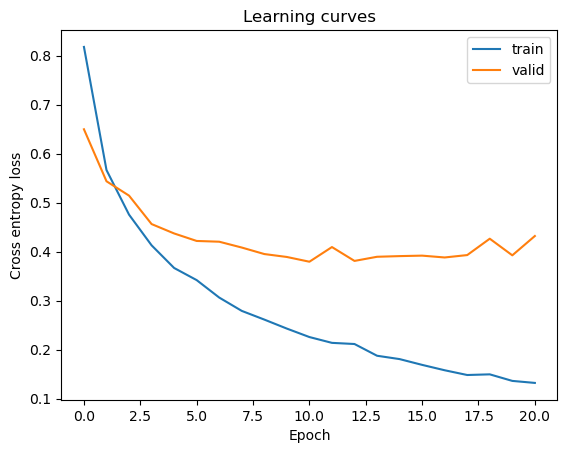

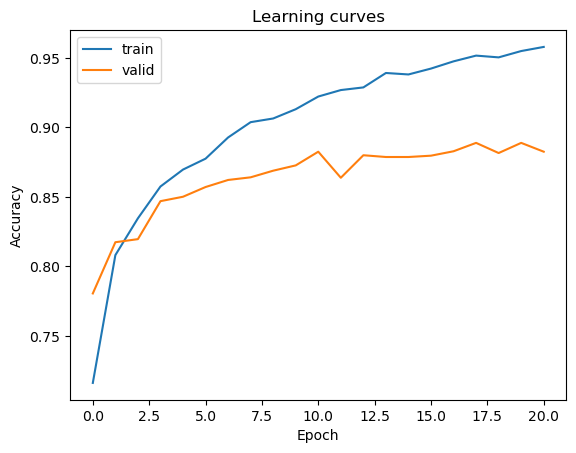

In [14]:
plot_history(history=history)

We notice that the simple CNN is overfitting slightly. Now we can try again  where we introduce drop out layers, more convolutional layers + pooling layers that reduce the amount of features and 

In [15]:
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights=True)

cnn = tf.keras.models.Sequential([
    layers.Conv2D(16, 3, activation='relu', padding='same', input_shape=X_train[0].shape),
    layers.SpatialDropout2D(.4),
    layers.AveragePooling2D(),
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.SpatialDropout2D(.4),
    layers.AveragePooling2D(),
    layers.Conv2D(120, 3, activation='relu', padding='same'),
    layers.SpatialDropout2D(.4),
    layers.Flatten(),
    layers.Dense(units=84, activation='relu'),
    layers.Dropout(.4),
    layers.Dense(units=4, activation='softmax')
])

cnn.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), metrics = ['accuracy'])
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 62, 65, 16)        160       
                                                                 
 spatial_dropout2d (SpatialD  (None, 62, 65, 16)       0         
 ropout2D)                                                       
                                                                 
 average_pooling2d_1 (Averag  (None, 31, 32, 16)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 31, 32, 32)        4640      
                                                                 
 spatial_dropout2d_1 (Spatia  (None, 31, 32, 32)       0         
 lDropout2D)                                                     
                                                      

In [16]:
history = cnn.fit(X_train, y_train, 
                    epochs = 100, 
                    validation_data=(X_validation, y_validation),
                    callbacks=[es])

Epoch 1/100


296/296 [==============================] - 35s 117ms/step - loss: 1.0015 - accuracy: 0.5922 - val_loss: 0.8445 - val_accuracy: 0.6839
Epoch 2/100
296/296 [==============================] - 30s 101ms/step - loss: 0.8288 - accuracy: 0.6805 - val_loss: 0.7307 - val_accuracy: 0.7290
Epoch 3/100
296/296 [==============================] - 28s 96ms/step - loss: 0.7505 - accuracy: 0.6976 - val_loss: 0.6679 - val_accuracy: 0.7363
Epoch 4/100
296/296 [==============================] - 30s 103ms/step - loss: 0.6905 - accuracy: 0.7223 - val_loss: 0.6098 - val_accuracy: 0.7659
Epoch 5/100
296/296 [==============================] - 34s 115ms/step - loss: 0.6544 - accuracy: 0.7386 - val_loss: 0.5662 - val_accuracy: 0.7846
Epoch 6/100
296/296 [==============================] - 31s 106ms/step - loss: 0.6229 - accuracy: 0.7510 - val_loss: 0.5448 - val_accuracy: 0.7795
Epoch 7/100
296/296 [==============================] - 41s 137ms/step - loss: 0.5961 - accuracy: 0.7640 - val_loss: 0.5028 - val_accuracy

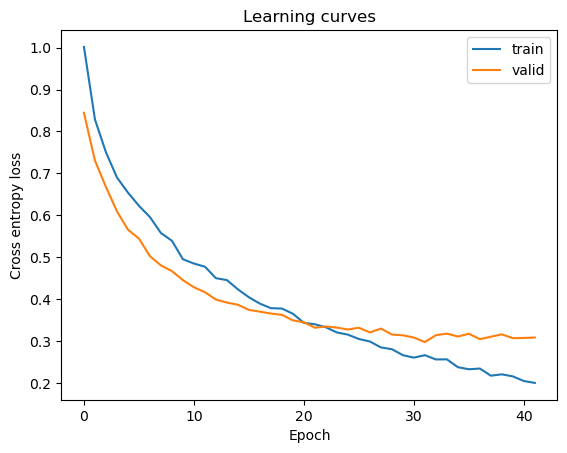

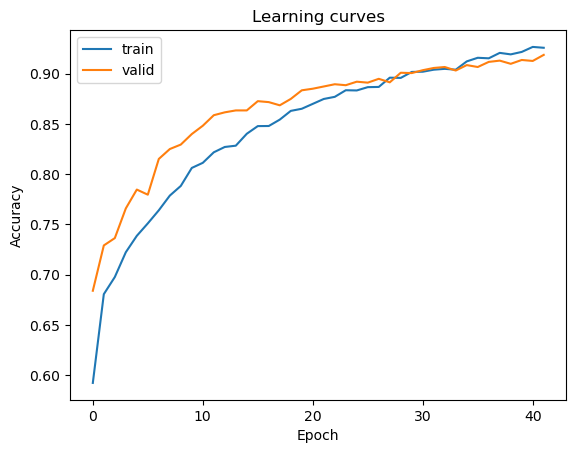

In [17]:
plot_history(history=history)

The combination of dropouts and more pooling layers reduced the overfitting. Increasing the amount of convolutional and pooling layers also increased the performance of the model signifcantly. 

In [23]:
cnn.save_weights('trained_model_weights')

CNNs should be good for this kind of problems, since the spectograms are basically images. 

__(b)__ Classify instances of the test set using your models. Draw a confusion matrix and comment on the results.

In [29]:
def argmax_output(output: np.ndarray) -> np.array:
    processed = list(map(lambda x: np.argmax(x), output))
    return np.array(processed)

In [32]:
from sklearn.metrics import recall_score, precision_score, classification_report

results = cnn.evaluate(X_test, y_test, batch_size=128)
predicitions = argmax_output(cnn.predict(X_test))
print("test accuracy: ", results[1])
print(classification_report(argmax_output(y_test), predicitions))


99/99 [==============================] - 2s 20ms/step
test accuracy:  0.9056543707847595
              precision    recall  f1-score   support

           0       0.84      0.87      0.85       810
           1       0.85      0.85      0.85       781
           2       0.97      0.95      0.96       752
           3       0.97      0.96      0.96       805

    accuracy                           0.91      3148
   macro avg       0.91      0.91      0.91      3148
weighted avg       0.91      0.91      0.91      3148



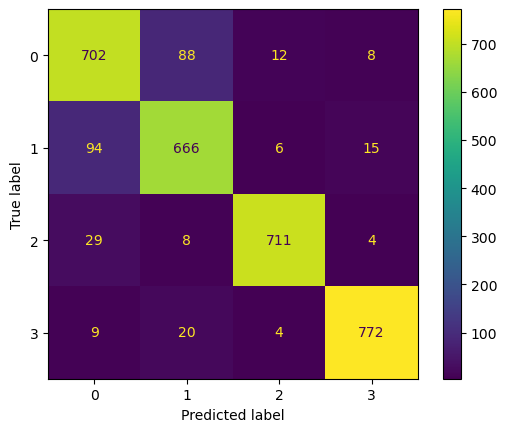

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(argmax_output(y_test), predicitions)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot()
plt.show()


The model seem to be confused about `yes` and `no` the most. It classfied 94 `no` as `yes` and 88 `yes` as `no`. This is also reflected in the lower recall and precision for class 0 and 1 compared to 2 and 3.

__(c)__ Choose one other algorithm from the course, and redo (a) and (b) using this algorithm. Supply a brief discussion of why we would expect this algorithm to do better/worse than the CNN.

We will retry with a K-Nearest Neighbour classifier. We would expect that this model performs worse than the CNN since the spectograms has complex patterns. KNN expects 2d input data, so we must first flatten the data.

In [38]:
nsamples, nx, ny, nz = X.shape
X_flattened = X.reshape((nsamples, nx*ny*nz))

In [62]:
pd.DataFrame(X_flattened).head()

,0,1,2,3,4,5,6,7,8,9,...,4020,4021,4022,4023,4024,4025,4026,4027,4028,4029
0,0.000202,0.001018,0.000571,0.004213,0.001055,0.001251,0.001950,0.000917,0.001477,0.001207,...,0.000713,0.000847,0.000591,0.000851,0.000462,0.000050,0.000088,0.000101,0.000089,6.552655e-05
1,0.002514,0.040008,0.022006,0.004498,0.005044,0.019931,0.006619,0.006830,0.004443,0.017755,...,0.001878,0.000681,0.000361,0.000642,0.000261,0.000364,0.000059,0.000160,0.000079,5.407445e-05
2,0.000346,0.002116,0.002488,0.001345,0.006712,0.001155,0.000621,0.001105,0.000184,0.004455,...,0.000219,0.000141,0.000185,0.000103,0.000120,0.000199,0.000146,0.000039,0.000066,1.634215e-05
3,0.000108,0.000225,0.000434,0.000194,0.000230,0.000308,0.000236,0.000216,0.000146,0.000089,...,0.000050,0.000125,0.000240,0.000014,0.000095,0.000092,0.000232,0.000147,0.000096,1.433338e-04
4,0.000151,0.000300,0.000769,0.002427,0.004037,0.000700,0.002485,0.000369,0.000479,0.000116,...,0.000141,0.000278,0.000253,0.000427,0.000163,0.000060,0.000048,0.000099,0.000043,7.322524e-08


Since K-Nearest usees distance, we should scale the data.

In [63]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_flattened_scaled = scaler.fit_transform(X_flattened)

In [64]:
from sklearn.model_selection import train_test_split

X_, X_test, y_, y_test = train_test_split(X_flattened_scaled, y, test_size=.2, random_state=42)
X_train, X_validation, y_train, y_validation= train_test_split(X_, y_, test_size=.25, random_state=42)

Grid search for the best hyper parameters. We would have liked to use more parameters, but the training took too long (40 minutes+)

In [67]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

hyperparam_grid = {'metric': ['l1'], 'n_neighbors': [x for x in range(2, 3)]}

gs_knn = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=hyperparam_grid)
gs_knn.fit(X_train, y_train)


GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'metric': ['l1'], 'n_neighbors': [2]})

In [69]:
preds_train = gs_knn.predict(X_train)

Training report


In [75]:
print("Training report")
print(classification_report(argmax_output(y_train), argmax_output(preds_train)))

Training report
              precision    recall  f1-score   support

           0       0.60      1.00      0.75      2285
           1       1.00      0.73      0.84      2384
           2       1.00      0.77      0.87      2328
           3       1.00      0.86      0.92      2444

    accuracy                           0.84      9441
   macro avg       0.90      0.84      0.85      9441
weighted avg       0.90      0.84      0.85      9441



In [76]:
preds_test = gs_knn.predict(X_test)

In [77]:
print("Test report")
print(classification_report(argmax_output(y_test), argmax_output(preds_test)))

Test report
              precision    recall  f1-score   support

           0       0.47      0.82      0.60       810
           1       0.66      0.54      0.59       781
           2       0.98      0.60      0.75       752
           3       0.99      0.77      0.87       805

    accuracy                           0.69      3148
   macro avg       0.77      0.68      0.70      3148
weighted avg       0.77      0.69      0.70      3148



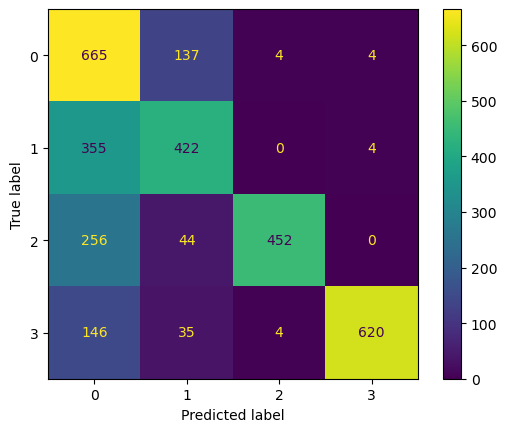

In [79]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(argmax_output(y_test), argmax_output(preds_test))
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot()
plt.show()

In [80]:
X_flattened_scaled.shape

(15737, 4030)

The CNN outperforms the KNN as expected. One of the reasons is the data is high dimensional with 4030 features. Similar data points that should be close together might not be close to each other when put in higher dimension (curse of dimensionality), i.e. data is scatted sparsly.

KNN also treat all features equally when calculating the distance, altough not all features are of equal importance. CNN is able to account for this because of weights between nodes and feature maps, thus CNN generlise better for this type of task.